In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize
from sklearn.calibration import CalibratedClassifierCV

In [176]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [177]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [178]:
git_dir = 'C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/'

In [179]:
weather_rename_dict = pd.read_pickle(os.path.join(git_dir, 'data/clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))
mod_lr = pd.read_pickle(os.path.join(git_dir, 'models/LR_30entropy_1990_2015.pkl'))
mod_svm = pd.read_pickle(os.path.join(git_dir, 'models/linSVC_30entropy_1990_2015_a.pkl'))
feat_list = pd.read_pickle(os.path.join(git_dir, 'models/feature_lists/RF_entropy_top30_features.pkl'))

In [180]:
target_df1 = pd.read_pickle(os.path.join(git_dir, 'data/clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(git_dir, 'data/clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

In [181]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Binary Target Variable

In [305]:
train_stage1_data = target_df[(target_df['YEAR']>1989) & (target_df['YEAR']<=2005)]
X_train_stage1 = train_stage1_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train_stage1.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_stage1_bin = train_stage1_data['Y_bin_new_fire_month'].to_frame()
#Y_train_stage1_area = train_stage1_data['Y_fire_area_prop'].to_frame()
#Y_train_stage1_area = np.log(train_stage1_data['Y_fire_area_prop'] + 1).to_frame()
Y_train_stage1_area = np.sqrt(train_stage1_data['Y_fire_area_prop']).to_frame()

In [306]:
train_stage2_data = target_df[(target_df['YEAR']>2005) & (target_df['YEAR']<=2016)]
X_train_stage2 = train_stage2_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train_stage2.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_stage2_bin = train_stage2_data['Y_bin_new_fire_month'].to_frame()
#Y_train_stage2_area = train_stage2_data['Y_fire_area_prop'].to_frame() 
#Y_train_stage2_area = np.log(train_stage2_data['Y_fire_area_prop'] + 1).to_frame() 
Y_train_stage2_area = np.sqrt(train_stage2_data['Y_fire_area_prop']).to_frame() 

In [307]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_bin = test_data['Y_bin_new_fire_month'].to_frame()
#Y_test_area = test_data['Y_fire_area_prop'].to_frame()
#Y_test_area = np.log(test_data['Y_fire_area_prop'] + 1).to_frame()
Y_test_area = np.sqrt(test_data['Y_fire_area_prop']).to_frame()

In [308]:
X_train_stage1_scaled = pd.DataFrame(scale(X_train_stage1), columns = X_train_stage1.columns)
X_train_stage2_scaled = pd.DataFrame(scale(X_train_stage2), columns = X_train_stage2.columns)
X_test_scaled = pd.DataFrame(scale(X_test), columns = X_test.columns)

## Create Classification Model Using First Training Set

In [309]:
mod_cl = LogisticRegression(C=0.01, class_weight='balanced')
mod_cl.fit(X_train_stage1_scaled[feat_list], Y_train_stage1_bin['Y_bin_new_fire_month'])

LogisticRegression(C=0.01, class_weight='balanced')

In [310]:
#mod_cl = LinearSVC(C=0.0001, class_weight='balanced', dual=False)
#mod_cl.fit(X_train_stage1_scaled[feat_list], Y_train_stage1_bin['Y_bin_new_fire_month'])

In [311]:
mod_cl_2 = CalibratedClassifierCV(mod_cl)
mod_cl_2.fit(X_train_stage1_scaled[feat_list], Y_train_stage1_bin['Y_bin_new_fire_month'])

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.01,
                                                         class_weight='balanced'))

## Generate Input for Regression Model Using Second Training Set

In [312]:
preds_stage1 = mod_cl.predict(X_train_stage2_scaled[feat_list])
preds_proba_stage1 = mod_cl_2.predict_proba(X_train_stage2_scaled[feat_list])[:, 1]

In [313]:
X_train_stage2['preds_stage1'] = preds_stage1
Y_train_stage2_area['preds_stage1'] = preds_stage1
X_train_stage2['preds_proba_stage1'] = preds_proba_stage1
Y_train_stage2_area['preds_proba_stage1'] = preds_proba_stage1

X_train_stage2 = X_train_stage2[X_train_stage2['preds_stage1'] == 1]
Y_train_stage2_area = Y_train_stage2_area[Y_train_stage2_area['preds_stage1'] == 1]

## Create Regression Model Using Filtered Second Training Set

In [314]:
# Fit model
#mod_reg = LinearRegression()
#mod_reg.fit(X_train_stage2[feat_list], Y_train_stage2_area['Y_fire_area_prop'])

In [315]:
# Fit model
#mod_reg = Ridge()
#mod_reg.fit(X_train_stage2[feat_list], Y_train_stage2_area['Y_fire_area_prop'])

In [316]:
# Fit model
mod_reg = RandomForestRegressor(n_estimators=500, min_samples_leaf=30)
mod_reg.fit(X_train_stage2[feat_list], Y_train_stage2_area['Y_fire_area_prop'])

RandomForestRegressor(min_samples_leaf=30, n_estimators=500)

## Generate Input for Regression Model Using Test Set

In [317]:
# Predict using stage 1 model to identify positive instances
preds_stage1 = mod_cl.predict(X_test_scaled[feat_list])
preds_proba_stage1 = mod_cl_2.predict_proba(X_test_scaled[feat_list])[:, 1]

In [318]:
# Create a filtered test df of just the instances flagged as positive from the stage 1 model
X_test['preds_stage1'] = preds_stage1
Y_test_area['preds_stage1'] = preds_stage1
X_test['preds_proba_stage1'] = preds_proba_stage1
Y_test_area['preds_proba_stage1'] = preds_proba_stage1

X_test_filtered = X_test[X_test['preds_stage1'] == 1]
Y_test_filtered_area = Y_test_area[Y_test_area['preds_stage1'] == 1]

## Score Regression Model on Filtered Test and Full Test

In [319]:
# Score on the instances flagged as positive from the stage 1 model
preds_stage2 = mod_reg.predict(X_test_filtered[feat_list])
r2_score(Y_test_filtered_area['Y_fire_area_prop'], preds_stage2)

0.29031365996392633

In [320]:
# Join our predictions back on the full test df and null fill with 0s (we predict an area of 0 if the stage 1 model predicts 0)
X_test_filtered['preds_stage2'] = preds_stage2

#X_test = X_test.merge(X_test_filtered['preds_stage2'], how='left', left_index=True, right_index=True)
#X_test['preds_stage2'] = X_test['preds_stage2'].fillna(0)

<ipython-input-320-4eb6f0ff063e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_filtered['preds_stage2'] = preds_stage2


In [321]:
X_test = X_test.merge(X_test_filtered['preds_stage2'], how='left', left_index=True, right_index=True)

In [322]:
X_test['preds_stage2'] = X_test['preds_stage2'].fillna(0)

In [323]:
# Score on all test instances
r2_score(Y_test_area['Y_fire_area_prop'], X_test['preds_stage2'])

0.18131147726973673

In [324]:
## Split test actuals into buckets
## Calculate the mean for each bucket
## Apply predictions to the test group
## Group the predictions in the same way as the first grouping and calculate the prediction mean for each bucket

In [325]:
set_1 = Y_test_filtered_area['Y_fire_area_prop'][(Y_test_filtered_area['Y_fire_area_prop'] >= Y_test_filtered_area['Y_fire_area_prop'].quantile(0)) & (Y_test_filtered_area['Y_fire_area_prop'] <= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.6))].index.values
set_2 = Y_test_filtered_area['Y_fire_area_prop'][(Y_test_filtered_area['Y_fire_area_prop'] >= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.61)) & (Y_test_filtered_area['Y_fire_area_prop'] <= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.7))].index.values
set_3 = Y_test_filtered_area['Y_fire_area_prop'][(Y_test_filtered_area['Y_fire_area_prop'] >= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.7)) & (Y_test_filtered_area['Y_fire_area_prop'] <= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.8))].index.values
set_4 = Y_test_filtered_area['Y_fire_area_prop'][(Y_test_filtered_area['Y_fire_area_prop'] >= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.8)) & (Y_test_filtered_area['Y_fire_area_prop'] <= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.9))].index.values
set_5 = Y_test_filtered_area['Y_fire_area_prop'][(Y_test_filtered_area['Y_fire_area_prop'] >= Y_test_filtered_area['Y_fire_area_prop'].quantile(0.9)) & (Y_test_filtered_area['Y_fire_area_prop'] <= Y_test_filtered_area['Y_fire_area_prop'].quantile(1))].index.values

In [326]:
actuals = []

actuals.append(Y_test_filtered_area['Y_fire_area_prop'][set_1].mean())
actuals.append(Y_test_filtered_area['Y_fire_area_prop'][set_2].mean())
actuals.append(Y_test_filtered_area['Y_fire_area_prop'][set_3].mean())
actuals.append(Y_test_filtered_area['Y_fire_area_prop'][set_4].mean())
actuals.append(Y_test_filtered_area['Y_fire_area_prop'][set_5].mean())

actuals

[3.1945681114505325e-05,
 0.004494061944232703,
 0.011189509197727132,
 0.02950711862928163,
 0.15711333665023552]

In [327]:
preds = []

preds.append(X_test_filtered['preds_stage2'][set_1].mean())
preds.append(X_test_filtered['preds_stage2'][set_2].mean())
preds.append(X_test_filtered['preds_stage2'][set_3].mean())
preds.append(X_test_filtered['preds_stage2'][set_4].mean())
preds.append(X_test_filtered['preds_stage2'][set_5].mean())

preds

[0.012227983987605844,
 0.016474099334296714,
 0.018026014103753468,
 0.01971043041834076,
 0.06000867978783855]

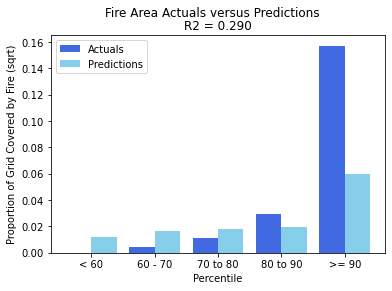

In [329]:
x1_values = [0.8,1.8,2.8,3.8,4.8]
x2_values = [1.2,2.2,3.2,4.2,5.2]

plt.figure()

plt.bar(x1_values, actuals, width=0.4, color='royalblue', label='Actuals')
plt.bar(x2_values, preds, width=0.4, color='skyblue', label='Predictions')

plt.suptitle('Fire Area Actuals versus Predictions')
plt.title('R2 = 0.290')
plt.xlabel('Percentile')
plt.ylabel('Proportion of Grid Covered by Fire (sqrt)')
plt.xticks([1,2,3,4,5], ['< 60', '60 - 70', '70 to 80', '80 to 90', '>= 90'])
plt.legend()
